### Install the library and download the dataset

In [22]:
!pip install 'aif360[LFR]'

In [23]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [24]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2022-02-16 16:34:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.2’

adult.data.2        100%[===================>]   3.79M  7.42MB/s    in 0.5s    

2022-02-16 16:34:42 (7.42 MB/s) - ‘adult.data.2’ saved [3974305/3974305]

--2022-02-16 16:34:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names.2’

adult.names.2       100%[===================>]   5.11K  --.-KB/s    in 0s      


In [25]:
# Import the libraries and set the random seed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from aif360.metrics import ClassificationMetric
from aif360.sklearn import metrics
from aif360.algorithms.preprocessing.reweighing import Reweighing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import *

np.random.seed(0)

In [26]:
# Define the sensitive feature in the dataset - here I choose 'sex'
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_adult(['sex'])

# Split between training and test set (0.7/0.3)
train, test = dataset_orig.split([0.7], shuffle=True)
print("training data size", train.features.shape)
print("dataset feature names", train.feature_names)

# Split the training data into 5 folds
folds = 5
folds_data = train.split(folds) 

# Normalize the dataset, both train and test
# Use MinMax scaler on data so that categorical features are not changed
scale_orig = MinMaxScaler()
X_train = scale_orig.fit_transform(train.features)
y_train = train.labels.ravel()

# Fit the scaler on the training data
scaler = scale_orig.fit(train.features)
# Apply the same scaling on the test data
X_test = scaler.transform(test.features) 
y_test = test.labels.ravel()

training data size (34189, 18)
dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


# Logistic Regression

In [27]:
# In logistic regression, C represents the inverse of regularisation strength 
values_C = [1e-15, 1e-12, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 
            1e-3, 1e-2, 1e-1, 1e-0, 1e+2, 1e+5, 1e+8, 1e+10, 1e+12, 1e+15] 

In [28]:
def cross_validation(folds, folds_data, reweigh=False, use_new_metric=False, remove_sensitive_feature=False):

    # Store the metrics across folds in a dictionary of dictionaries
    metric_arrs = dict() 

    # If reweighing, transform the original dataset by sentitive features
    if reweigh==True: RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    for value in values_C:
        metric_arrs[str(value)] = dict()
        metric_arrs[str(value)]['acc'] = []
        metric_arrs[str(value)]['eq_opp_diff'] = []
        if use_new_metric==True: metric_arrs[str(value)]['new_metric'] = [] 

        for i in range(folds): 
            # Create the validation set
            val = folds_data[i]
            val_labels = val.labels.ravel()

            # Create the training set by concatenating the remaining folds 
            train_set = folds_data[i+1:] + folds_data[:i]
            train_labels = [data.labels.ravel() for data in train_set]
            if reweigh==True: train_weights = [RW.fit(train).transform(data).instance_weights for data in train_set] 
            train_set = [scaler.transform(data.features) for data in train_set]
            train_X = np.concatenate(train_set, axis=0)
            # print(train_X.shape)
            if remove_sensitive_feature==True: train_X = np.delete(train_X, 1, 1) # Remove 'sex'
            train_y = np.concatenate(train_labels)
            if reweigh==True: train_weights = np.concatenate(train_weights, axis=0)

            # Fit the logistic regression model
            learner = LogisticRegression(solver='liblinear', random_state=1, C=value) 
            # If reweighing, use the instance weights in the training phase
            if reweigh==True: learner.fit(train_X, train_y, sample_weight=train_weights)
            else: learner.fit(train_X, train_y)

            # Make predictions on the validation set
            X_val = scaler.transform(val.features)
            if remove_sensitive_feature==True: X_val = np.delete(X_val, 1, 1) # Remove 'sex'
            predictions = learner.predict(X_val)
            val_pred = val.copy()
            val_pred.labels = predictions
            
            # Compute the accuracy
            acc = sum(predictions==val_labels)/len(val_labels)
            metric_arrs[str(value)]['acc'].append(acc)

            metric = ClassificationMetric(val, val_pred, unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
            # Compute the equality of opportunity difference (EOOD)
            # The closer to 0 the better, if smaller than zero implies bias towards the priviledged group
            eq_opp_diff = metric.equal_opportunity_difference()
            metric_arrs[str(value)]['eq_opp_diff'].append(eq_opp_diff)

            # Compute the new metric defined as (accuracy - |EOOD|)
            new_metric = acc-np.abs(eq_opp_diff)
            if use_new_metric==True: metric_arrs[str(value)]['new_metric'].append(new_metric)


    # Replace the inner dictionary values with the averaged metrics across the folds
    for key in metric_arrs.keys(): 
        for inner_key in metric_arrs[key].keys():
            avg_metric = sum(metric_arrs[key][inner_key])/len(metric_arrs[key][inner_key])
            metric_arrs[key][inner_key] = avg_metric
    
    # Create lists of metrics for plotting
    acc = []
    eq_opp = []
    if use_new_metric==True: new_metric = []

    for key in metric_arrs.keys():
        acc.append(metric_arrs[key]['acc'])
        eq_opp.append(metric_arrs[key]['eq_opp_diff'])
        if use_new_metric==True: new_metric.append(metric_arrs[key]['new_metric'])

    if use_new_metric==True: return metric_arrs, acc, eq_opp, new_metric
    else: return metric_arrs, acc, eq_opp

In [29]:
def print_CV_results(metric_arrs):
    for key in metric_arrs.keys():
        print(float(key), metric_arrs[key])

In [30]:
def plot_metrics(acc, eq_opp, new_metric=None, reweigh=False, use_new_metric=False):
    plt.plot(values_C, acc, label="Accuracy", marker="D", color='navy')
    plt.plot(values_C, eq_opp, label="Equality of Opportunity Differece (EOOD)", marker="o", color = 'red')
    if use_new_metric==True: plt.plot(values_C, new_metric, label="Accuracy-|EOOD|", marker="v", color='orange')
    
    plt.legend()
    plt.grid(True)
    plt.xscale("log")

    plt.xlabel("Regularisation hyperparamater (on log scale)")
    if reweigh==True: plt.title("Logistic Regression: Accuracy and Fairness metrics on Reweighted data")
    else: plt.title("Logistic Regression: Accuracy and Fairness metrics")

    plt.show()

In [31]:
def evaluate_on_test_set(best_values_C, reweigh=False, use_new_metric=False, remove_sensitive_feature=False):

    global X_train, X_test

    metric_arrs = dict()

    if reweigh==True: 
        RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        train_weights = RW.fit_transform(train).instance_weights

    if remove_sensitive_feature==True: 
        X_train = np.delete(X_train, 1, 1) # Remove 'sex'
        X_test = np.delete(X_test, 1, 1) # Remove 'sex'

    for value in best_values_C:
        metric_arrs[str(value)] = dict()
        metric_arrs[str(value)]['acc'] = []
        metric_arrs[str(value)]['eq_opp_diff'] = []
        if use_new_metric==True: metric_arrs[str(value)]['new_metric'] = []

        learner = LogisticRegression(solver='liblinear', random_state=1, C=value)  
        if reweigh==True: learner.fit(X_train, y_train, sample_weight = train_weights)
        else: learner.fit(X_train, y_train)

        # Make predictions on the test set
        predictions = learner.predict(X_test)
        test_pred = test.copy()
        test_pred.labels = predictions

        acc = sum(predictions==y_test)/len(y_test)
        metric_arrs[str(value)]['acc'].append(acc)

        metric = ClassificationMetric(test, test_pred, unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
        eq_opp_diff = metric.equal_opportunity_difference()
        metric_arrs[str(value)]['eq_opp_diff'].append(eq_opp_diff)

        new_metric = acc-np.abs(eq_opp_diff)
        if use_new_metric==True: metric_arrs[str(value)]['new_metric'].append(new_metric)

    print(metric_arrs)

# Task 1

1e-15 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-12 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-10 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-09 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-08 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-07 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-06 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-05 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
0.0001 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
0.001 {'acc': 0.7617068842806567, 'eq_opp_diff': -0.024008538622934627}
0.01 {'acc': 0.8028898296662993, 'eq_opp_diff': -0.46827905858904434}
0.1 {'acc': 0.8039135635835208, 'eq_opp_diff': -0.46394397038379864}
1.0 {'acc': 0.804001308538186, 'eq_opp_diff': -0.4658335052675196}
100.0 {'acc': 0.804001308538186, 'eq_opp_diff': -0.4658335052675196}
100000.0 {'acc': 0.804001308538186, 'eq_opp_diff': -0.4658335052675196}
100000000.0 {'acc': 0.804001308538186, 'eq_opp_diff': -0.4658335052675196}
10000000000.0 {'acc

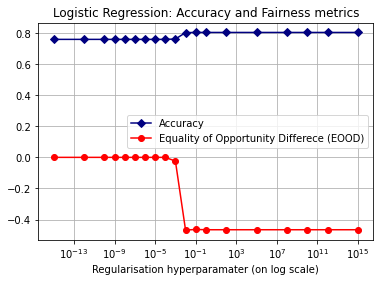

In [34]:
cv_results, acc, eq_opp = cross_validation(folds, folds_data, reweigh=False, use_new_metric=False)
print_CV_results(cv_results)
plot_metrics(acc, eq_opp, reweigh=False, use_new_metric=False)

**Observation** 

Varying the hyperparameter value has an expected accuracy-fairness trade-off: 


*   Larger C values, C>=1, have weak regularisation, which leads to higher accuracy but generally poorer fairness metrics (despite the spike at C=1e-2). 
*   Smaller C values lead to stronger regularisation, as the result the models have lower accuracy, but improved fairness metrics.



### Evaluate on the test set

In [35]:
# Evaluating Models 1 & 2 on the test set
best_values_C = [1e+2, 1e-5] # Both values are randomly chosen among several best C values
evaluate_on_test_set(best_values_C, reweigh=False, use_new_metric=False)

{'100.0': {'acc': [0.8042039172865625], 'eq_opp_diff': [-0.4414141414141414]}, '1e-05': {'acc': [0.763734388862349], 'eq_opp_diff': [0.0]}}


**Observation** 

Compare Model 1 & 2, the absolute value of EOOD decreases to zero by 0.15 for Model 2 with only a small drop (0.03) in accuracy, showing that adopting the fairness metric on the orginal Adult data may be a better approach in terms of both accuracy and fairness.

# Task 2

Let's use **Reweighing**, a method to tackle dataset bias by applying a weight to the training datapoints, so that some are considered more than others in the computation of the loss function.

1e-15 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-12 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-10 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-09 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-08 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-07 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-06 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
1e-05 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
0.0001 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0}
0.001 {'acc': 0.7577289718302803, 'eq_opp_diff': 0.03586690260252561}
0.01 {'acc': 0.7806021406072793, 'eq_opp_diff': 0.11444704879211876}
0.1 {'acc': 0.7891427179751558, 'eq_opp_diff': -0.005560663503746366}
1.0 {'acc': 0.789405991340667, 'eq_opp_diff': -0.010804109196630263}
100.0 {'acc': 0.789405991340667, 'eq_opp_diff': -0.010804109196630263}
100000.0 {'acc': 0.789405991340667, 'eq_opp_diff': -0.010804109196630263}
100000000.0 {'acc': 0.789405991340667, 'eq_opp_diff': -0.010804109196630263}
10000000000.0

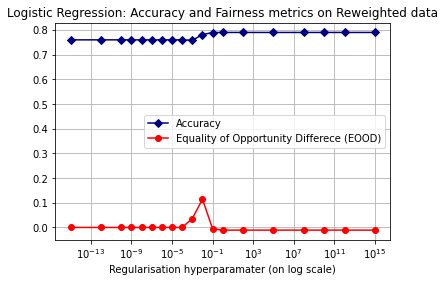

In [36]:
cv_results, acc, eq_opp = cross_validation(folds, folds_data, reweigh=True, use_new_metric=False)
print_CV_results(cv_results)
plot_metrics(acc, eq_opp, reweigh=True, use_new_metric=False)

**Observation** 

Varying the hyperparameter value does not display significant accuracy-fairness trade-off: 


*   Larger C values, C>=1, have weak regularisation, which leads to higher accuracy but mostly stable values of fairness metric around zero. This indicates that reweighing helps to correct bias in data and thus reduce the magnitude of EOOD.
*   Note that an outlier occurs at C = 0.001 where there is a big jump in bias (EOOD ~= 0.4) towards the unpriviledged groups.



### Evaluate on the test set

In [37]:
# Evaluating Models 3 & 4 on the test set
best_values_C = [1e+2, 1e-5] # Both values are randomly chosen among several best C values
evaluate_on_test_set(best_values_C, reweigh=True, use_new_metric=False)

{'100.0': {'acc': [0.7905548351873336], 'eq_opp_diff': [0.03513180586351322]}, '1e-05': {'acc': [0.763734388862349], 'eq_opp_diff': [0.0]}}


**Observation** 

Compare Model 1 & 2, both Model 3 & 4 have very small EOOD values (near zero) and similar accuracies on the test set, although selected based on different metrics, showing the effectiveness of reweighing in correcting bias.



# Task 3

Here I propose a new model selection metric: accuracy - |equality of opportunity difference|, to account for both accuracy and fairness. 
We should select models with hyperparameter(s) that maximises this criteria.

### Standard ML model

1e-15 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-12 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-10 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-09 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-08 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-07 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-06 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-05 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
0.0001 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
0.001 {'acc': 0.7617068842806567, 'eq_opp_diff': -0.024008538622934627, 'new_metric': 0.7376983456577221}
0.01 {'acc': 0.8028898296662993, 'eq_opp_diff': -0.46827905858904434, 'new_metric': 0.334610771077254

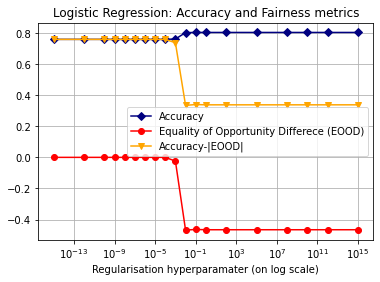

In [50]:
cv_results, acc, eq_opp, new_metric = cross_validation(folds, folds_data, reweigh=False, use_new_metric=True)
print_CV_results(cv_results)
plot_metrics(acc, eq_opp, new_metric, reweigh=False, use_new_metric=True)

**Observation** 

*   Larger C values, C>=1, have weak regularisation, which leads to higher accuracy but poorer value in the new metric. 
*   As C increases, the proposed new metric follows roughly a similar trend as the EOOD, with the same set of best C values.
*   This shows that when there is bias in data and/or algorithm and no effective correction of bias through e.g. reweighing, the |EOOD| values tend to be larger and dominate the contribution to the proposed new metric compared to accuracy.



### Fairness-based ML model

1e-15 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-12 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-10 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-09 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-08 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-07 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-06 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-05 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
0.0001 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
0.001 {'acc': 0.7577289718302803, 'eq_opp_diff': 0.03586690260252561, 'new_metric': 0.7218620692277548}
0.01 {'acc': 0.7806021406072793, 'eq_opp_diff': 0.11444704879211876, 'new_metric': 0.6443380134829053}


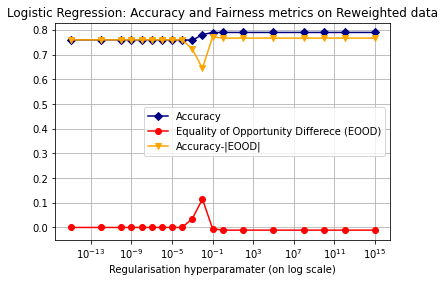

In [51]:
cv_results, acc, eq_opp, new_metric = cross_validation(folds, folds_data, reweigh=True, use_new_metric=True)
print_CV_results(cv_results)
plot_metrics(acc, eq_opp, new_metric, reweigh=True, use_new_metric=True)

**Observation** 

*   Larger C values, C>=1, have weak regularisation, which leads to higher accuracy and also in general a higher value in the new metric. 
*   As C increases, the proposed new metric follows a similar trend as the accuracy (despite at the big spike at C = 0.001 due to a large EOOD value). The set of best C values are the same for the new metric and the accuracy.
*   The EOOD values mostly stay around zero despite the change in C values.
*   This suggests that after we correct the bias using reweighing, EOOD contributes very little to the new metric and the main contribution comes from the accuracy.

### Evaluate on the test set

In [52]:
# Evaluating Models 5 & 6 on the test set
standard_best_C = [1e-7] # This value is randomly chosen among several best C values
fairness_best_C = [1e-1] 
evaluate_on_test_set(standard_best_C, reweigh=False, use_new_metric=True)
evaluate_on_test_set(fairness_best_C, reweigh=True, use_new_metric=True)

{'1e-07': {'acc': [0.763734388862349], 'eq_opp_diff': [0.0], 'new_metric': [0.763734388862349]}}
{'0.1': {'acc': [0.7596396642325803], 'eq_opp_diff': [0.014469902274780344], 'new_metric': [0.7451697619577999]}}


**Thoughts** 

*   With reweighting, the new metric value on the test set is actually slightly lower, with a suprisingly larger loss in EOOD and a slight gain in accuracy. This means that the best standard ML model slightly outperformd the best fairness ML model. This implies that to combat biases, choosing a model based on a metric that accounts for both accuracy and fairness could be a useful alternative to algorithmic fairness methods such as reweighting.

**Critique & Improvements** 
*   Here I chose to select 'sex' as the sentitive feature due to the steady gender wage gap observed in almost all countries. Further work could also consider 'race' as a sentitive feature and apply e.g. reweighing or remove 'race' from the features and see how performances of models change. Applying these steps could give us insights on whether the dataset is more biased towards 'sex' or 'race'. Extention of fairness metrics and methods to non-binary sensitive features such as 'age' could also be an useful next step.

*   Here I used the same test set throughout the cross-validation. One possible improvement is to do the train-val-test split multiple times after shuffling the data and average the metric values over multiple test sets.

* On this dataset, it is often that there are multiple best hyperparameter values which give equal metric values on the validation set. In such cases, I chose one of the best values randomly, but the metric values on the test set could be slightly different for other best values. One possible improvement is to evaluate all the best hyperparameter values on the test set and average the metrics over those values to produce more reliable test metrics.

*   To generalise the results, other classification models with reweighing could be applied, such as (boosted) decision trees and k-nearest neighbours, and compare the model performances with logistic regression.

# Extrapolation: Remove the Sensitive Feature - 'sex'

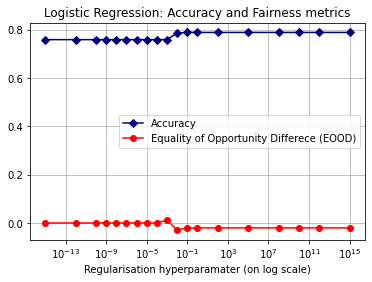

{'1000.0': {'acc': [0.7900088719033646], 'eq_opp_diff': [0.011328734499466198]}, '1e-08': {'acc': [0.763734388862349], 'eq_opp_diff': [0.0]}}


In [42]:
# Model 1 & 2: no significant changes
cv_results, acc, eq_opp = cross_validation(folds, folds_data, reweigh=False, use_new_metric=False, remove_sensitive_feature=True)
# print_CV_results(cv_results)
plot_metrics(acc, eq_opp, reweigh=False, use_new_metric=False)

# Evaluating Models 1 & 2 on the test set
best_values_C = [1e+3, 1e-8] # Both values are randomly chosen among several best C values
evaluate_on_test_set(best_values_C, reweigh=False, use_new_metric=False, remove_sensitive_feature=True)

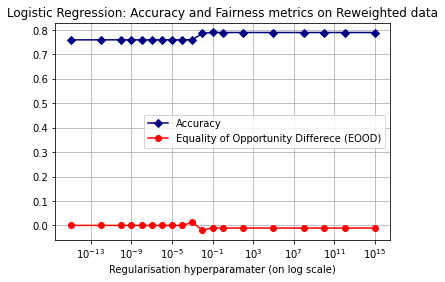

{'100000.0': {'acc': [0.7905548351873336], 'eq_opp_diff': [0.03513180586351322]}, '1e-09': {'acc': [0.763734388862349], 'eq_opp_diff': [0.0]}}


In [43]:
# Model 3 & 4: no significant changes
cv_results, acc, eq_opp = cross_validation(folds, folds_data, reweigh=True, use_new_metric=False, remove_sensitive_feature=True)
# print_CV_results(cv_results)
plot_metrics(acc, eq_opp, reweigh=True, use_new_metric=False)

# Evaluating Models 3 & 4 on the test set
best_values_C = [1e+5, 1e-9] # Both values are randomly chosen among several best C values
evaluate_on_test_set(best_values_C, reweigh=True, use_new_metric=False, remove_sensitive_feature=True)

1e-15 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-12 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-10 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-09 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-08 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-07 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-06 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-05 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
0.0001 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
0.001 {'acc': 0.7600104347663896, 'eq_opp_diff': 0.011858363979590983, 'new_metric': 0.7475371453296169}
0.01 {'acc': 0.7863640592969546, 'eq_opp_diff': -0.02958676240496408, 'new_metric': 0.7567772968919906

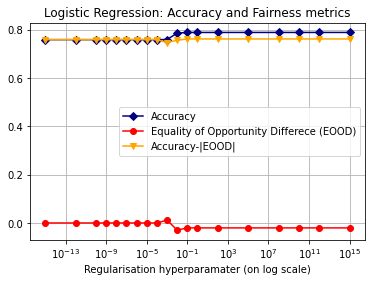

1e-15 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-12 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-10 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-09 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-08 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-07 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-06 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
1e-05 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
0.0001 {'acc': 0.7594254213445473, 'eq_opp_diff': 0.0, 'new_metric': 0.7594254213445473}
0.001 {'acc': 0.7600104347663896, 'eq_opp_diff': 0.011858363979590983, 'new_metric': 0.7475371453296169}
0.01 {'acc': 0.7858083412507423, 'eq_opp_diff': -0.019355989891031895, 'new_metric': 0.766452351359710

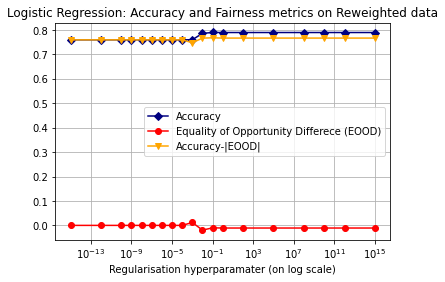

In [48]:
# Model 5 & 6: see some changes 
cv_results, acc, eq_opp, new_metric = cross_validation(folds, folds_data, reweigh=False, use_new_metric=True, remove_sensitive_feature=True)
print_CV_results(cv_results)
plot_metrics(acc, eq_opp, new_metric, reweigh=False, use_new_metric=True)

cv_results, acc, eq_opp, new_metric = cross_validation(folds, folds_data, reweigh=True, use_new_metric=True, remove_sensitive_feature=True)
print_CV_results(cv_results)
plot_metrics(acc, eq_opp, new_metric, reweigh=True, use_new_metric=True)

In [47]:
# Evaluating Models 5 & 6 on the test set
standard_best_C = [1e+3] # This value is randomly chosen among several best C values
fairness_best_C = [1e+7] # This value is randomly chosen among several best C values
evaluate_on_test_set(standard_best_C, reweigh=False, use_new_metric=True, remove_sensitive_feature=True)
evaluate_on_test_set(fairness_best_C, reweigh=True, use_new_metric=True, remove_sensitive_feature=True)

{'1000.0': {'acc': [0.7648263154302873], 'eq_opp_diff': [-0.009292108072595878], 'new_metric': [0.7555342073576915]}}
{'10000000.0': {'acc': [0.7596396642325803], 'eq_opp_diff': [0.014469902274780344], 'new_metric': [0.7451697619577999]}}
